In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
# import hypergrad as hg
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_GPU import ZSTL

In [2]:
net = FuncRecursiveNet([
    FLinearLayer(1, False)
])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
d = 8
dm = 5
T = 200
n = 20
dict_k = 6
shape_record = {}
shape_record[0] = [(1,d)]

def synthetic_binClass(d, dm, dict_k, T, n, random_state = 110):
    np.random.seed(110)
    L_gt = np.random.randn(d,dict_k)

    D_gt = np.random.randn(dm,dict_k)

    s = np.random.uniform(0, 2, size=(dict_k, T))
    s[s>=1] = 0

    ones = np.atleast_2d(np.ones(n))
    x = np.random.normal(0, 1.0, size=(d-1,n))*2
    x = np.vstack((ones, x))

    w = L_gt @ s
    a = D_gt @ s

    y = utils.sigmoid(w.T @ x)
    y[y >=0.5] = np.ones_like(y[y >=0.5])
    y[y <0.5] = np.zeros_like(y[y < 0.5])

    print('y ', np.sum(y, axis=1))

    a = a.T
    w = w.T
    x = x.T

    dataset = [(a[t,:], np.expand_dims(w[t,:], axis=0), x, np.expand_dims(y[t,:], axis=1)) for t in range(T)]

    print(a[1,:].shape, w[1,:].shape, x.shape, y[1,:].shape)
    return dataset

dataset = synthetic_binClass(d, dm, dict_k, T, n, random_state = 999)
print('len dataset ', len(dataset))
kb_size = 10
train_size = 140
total_len = len(dataset)
test_size = total_len - kb_size - train_size

indx = [ x for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
test_indx = temp
print(len(test_indx))


support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])

support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=train_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)
train_a, train_w, train_x, train_y = next(iter(train_loader))
train_a, train_w, train_x, train_y = train_a.float(), train_w.float(), train_x.float(), train_y.float()
print(train_a.shape, train_w.shape, train_x.shape, train_y.shape)

y  [12. 13. 17. 11.  7. 11. 11. 10.  8. 11. 11. 11. 11. 12. 17. 14. 15. 12.
 11.  8. 10. 14. 17. 17. 11. 16. 10. 10. 11. 12. 11. 11. 12. 16. 12. 11.
 11. 14. 14. 12. 17. 17.  9. 14. 11. 11. 12. 11. 13. 13. 10. 12. 12. 11.
 14. 16. 17. 14. 16. 13. 11. 15. 12. 12. 14. 15. 14. 16. 13. 13. 10. 13.
  9. 12. 10. 12. 12. 14. 10. 17. 11.  9. 11. 11. 10. 11. 14.  7. 12. 13.
 14. 12. 12. 11. 15. 15. 14. 13. 10. 14. 11. 11. 14. 16. 12. 17. 15. 12.
 13. 14. 11. 11. 20. 12. 11. 12. 14. 13. 12. 11. 12. 11. 11. 13. 14. 17.
 13. 12. 17. 12. 13. 16. 15.  7. 13. 13. 12. 11. 10. 16. 11. 11.  8. 10.
 13. 14.  9. 13.  8. 13. 20. 11. 10. 12. 11. 14. 11. 11. 11.  8.  9. 15.
 12. 14. 12. 12. 10. 14. 14. 13. 11. 10. 11. 13. 12. 14. 17. 17.  8. 16.
 11.  7. 14. 14. 13. 12. 11. 12. 15. 10. 14. 11. 12. 14. 11. 10. 14. 12.
 11. 11.]
(5,) (8,) (20, 8) (20,)
len dataset  200
10
140
50
torch.Size([140, 1, 5]) torch.Size([140, 1, 8]) torch.Size([140, 20, 8]) torch.Size([140, 20, 1])


5
8
20
120
120
20
num of hp  25
rho for w_kb 0.1; mu for a_kb 0.1;
init mean test metric 0.78; align loss 4.9283766746521
1/1500 o_loss 6.125453495668868; m train metric 0.8483333333333334; m test metric 0.78; align loss  4.92812967300415
100/1500 o_loss 5.122044858615846; m train metric 0.8558333333333338; m test metric 0.805; align loss  4.85277795791626
200/1500 o_loss 4.284847477497533; m train metric 0.8562500000000004; m test metric 0.8074999999999999; align loss  4.7783379554748535
300/1500 o_loss 3.649888744391501; m train metric 0.8612500000000002; m test metric 0.8375000000000001; align loss  4.705375671386719
400/1500 o_loss 3.1425065828332057; m train metric 0.8625000000000007; m test metric 0.8324999999999999; align loss  4.633768558502197
500/1500 o_loss 2.7241358652710916; m train metric 0.8625000000000005; m test metric 0.8300000000000001; align loss  4.5634355545043945
600/1500 o_loss 2.3766176061239093; m train metric 0.8637500000000001; m test metric 0.82999999999999

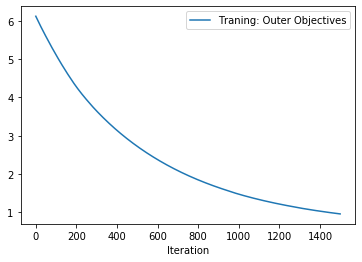

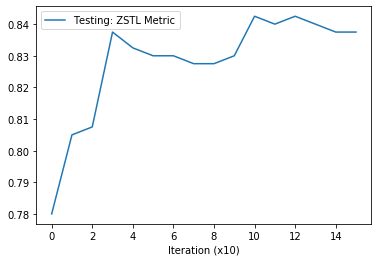

mean metric 0.8375
New best acc 0.8375
rho for w_kb 0.1; mu for a_kb 0.01;
init mean test metric 0.7799999999999999; align loss 0.5069708824157715
1/1500 o_loss 6.125453495668868; m train metric 0.8483333333333337; m test metric 0.78; align loss  0.5067238211631775
100/1500 o_loss 5.12204115060158; m train metric 0.8558333333333336; m test metric 0.805; align loss  0.49890413880348206
200/1500 o_loss 4.2848399843710165; m train metric 0.8562500000000001; m test metric 0.8074999999999999; align loss  0.49141404032707214
300/1500 o_loss 3.649886730018382; m train metric 0.8612500000000006; m test metric 0.8375; align loss  0.484157919883728
400/1500 o_loss 3.1425065494297693; m train metric 0.8625000000000004; m test metric 0.8325000000000001; align loss  0.4770626723766327
500/1500 o_loss 2.724148773821071; m train metric 0.8625000000000004; m test metric 0.8300000000000001; align loss  0.4700866639614105
600/1500 o_loss 2.3766478090547025; m train metric 0.8637500000000002; m test metr

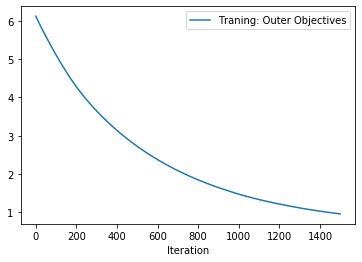

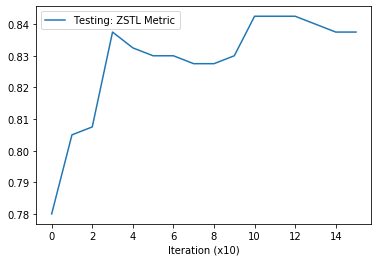

mean metric 0.8375000000000001
New best acc 0.8375000000000001
rho for w_kb 0.1; mu for a_kb 0.001;
init mean test metric 0.78; align loss 0.06483031809329987
1/1500 o_loss 6.125453495668868; m train metric 0.8483333333333338; m test metric 0.7800000000000001; align loss  0.06458325684070587
100/1500 o_loss 5.122261531790718; m train metric 0.8541666666666671; m test metric 0.805; align loss  0.06349930167198181
200/1500 o_loss 4.284330548873792; m train metric 0.85625; m test metric 0.8075000000000001; align loss  0.06269872188568115
300/1500 o_loss 3.6502015181196232; m train metric 0.861666666666667; m test metric 0.8375000000000001; align loss  0.06201980262994766
400/1500 o_loss 3.142662592449536; m train metric 0.8625000000000006; m test metric 0.8350000000000002; align loss  0.06138535961508751
500/1500 o_loss 2.7243904813658446; m train metric 0.8620833333333341; m test metric 0.8299999999999998; align loss  0.06075422093272209
600/1500 o_loss 2.376981354334081; m train metric 

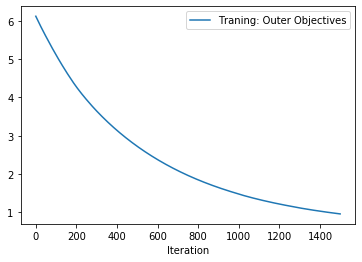

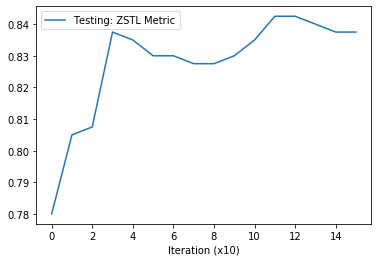

mean metric 0.8374999999999998
rho for w_kb 0.1; mu for a_kb 0.0001;
init mean test metric 0.78; align loss 0.020616261288523674
1/1500 o_loss 6.125453495668868; m train metric 0.8483333333333334; m test metric 0.78; align loss  0.02036920189857483
100/1500 o_loss 5.122283398872241; m train metric 0.8550000000000005; m test metric 0.8049999999999999; align loss  0.019789807498455048
200/1500 o_loss 4.283270139961193; m train metric 0.8558333333333336; m test metric 0.8099999999999999; align loss  0.019524158909916878
300/1500 o_loss 3.649771488892535; m train metric 0.8612500000000006; m test metric 0.8375; align loss  0.019390104338526726
400/1500 o_loss 3.1431976290264476; m train metric 0.8616666666666671; m test metric 0.835; align loss  0.019310934469103813
500/1500 o_loss 2.72537761128818; m train metric 0.8616666666666676; m test metric 0.8300000000000001; align loss  0.019250482320785522
600/1500 o_loss 2.3785637121492376; m train metric 0.8600000000000009; m test metric 0.8275

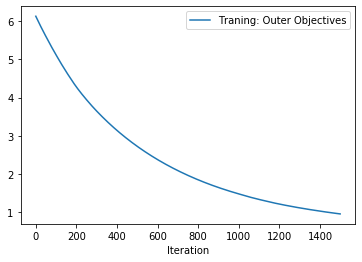

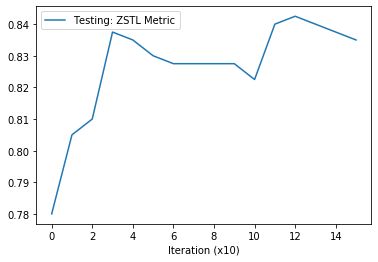

mean metric 0.835
rho for w_kb 0.1; mu for a_kb 1e-05;
init mean test metric 0.78; align loss 0.01619485579431057
1/1500 o_loss 6.125453495668868; m train metric 0.8483333333333337; m test metric 0.78; align loss  0.015947796404361725
100/1500 o_loss 5.121987527500218; m train metric 0.8541666666666672; m test metric 0.805; align loss  0.015392299741506577
200/1500 o_loss 4.282913674833253; m train metric 0.8550000000000002; m test metric 0.8100000000000002; align loss  0.015150260180234909
300/1500 o_loss 3.6496491638788333; m train metric 0.8612500000000003; m test metric 0.8375; align loss  0.015042440965771675
400/1500 o_loss 3.1429185996608187; m train metric 0.8608333333333338; m test metric 0.835; align loss  0.014989039860665798
500/1500 o_loss 2.7249329144290337; m train metric 0.8625000000000004; m test metric 0.8325000000000001; align loss  0.014960240572690964
600/1500 o_loss 2.3781010921734076; m train metric 0.8604166666666672; m test metric 0.8325000000000001; align loss

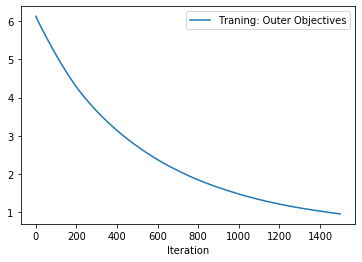

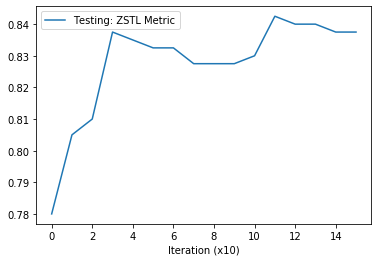

mean metric 0.8375
rho for w_kb 0.01; mu for a_kb 0.1;
init mean test metric 0.78; align loss 4.9283766746521
1/1500 o_loss 1.0630122658486167; m train metric 0.8483333333333337; m test metric 0.78; align loss  4.928131580352783
100/1500 o_loss 0.9013494405585031; m train metric 0.8558333333333334; m test metric 0.805; align loss  4.852938652038574
200/1500 o_loss 0.7502917228577037; m train metric 0.8566666666666671; m test metric 0.8200000000000001; align loss  4.77852725982666
300/1500 o_loss 0.6707549033065636; m train metric 0.8608333333333337; m test metric 0.8375; align loss  4.705531597137451
400/1500 o_loss 0.6172661760356277; m train metric 0.8670833333333339; m test metric 0.8424999999999999; align loss  4.633837699890137
500/1500 o_loss 0.5748319303461661; m train metric 0.8691666666666672; m test metric 0.8399999999999999; align loss  4.563423156738281
600/1500 o_loss 0.5397539693396538; m train metric 0.8716666666666676; m test metric 0.8324999999999999; align loss  4.494

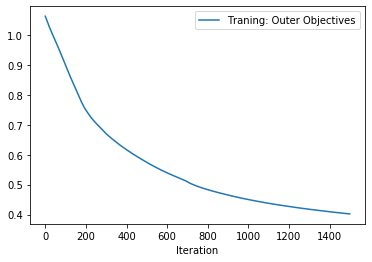

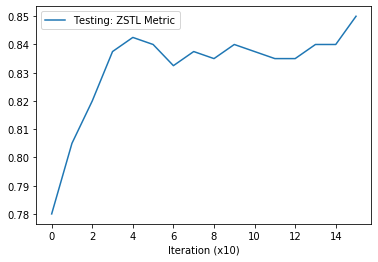

mean metric 0.85
New best acc 0.85
rho for w_kb 0.01; mu for a_kb 0.01;
init mean test metric 0.7800000000000001; align loss 0.5069708824157715
1/1500 o_loss 1.0630122658486167; m train metric 0.8483333333333334; m test metric 0.78; align loss  0.5067256093025208
100/1500 o_loss 0.90134471229588; m train metric 0.8558333333333338; m test metric 0.805; align loss  0.49906647205352783
200/1500 o_loss 0.750283599132672; m train metric 0.8566666666666675; m test metric 0.8200000000000001; align loss  0.49160245060920715
300/1500 o_loss 0.6707479419962814; m train metric 0.8608333333333341; m test metric 0.8374999999999998; align loss  0.48431196808815
400/1500 o_loss 0.6172600737307221; m train metric 0.8670833333333338; m test metric 0.8424999999999999; align loss  0.47713229060173035
500/1500 o_loss 0.574840981218343; m train metric 0.869583333333334; m test metric 0.8399999999999999; align loss  0.4700741767883301
600/1500 o_loss 0.5397588284686208; m train metric 0.8716666666666673; m 

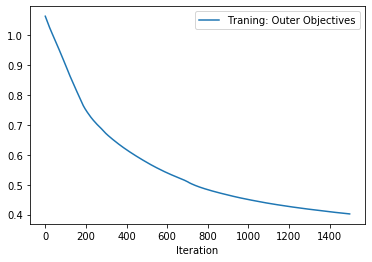

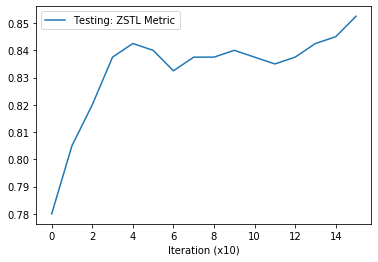

mean metric 0.8524999999999998
New best acc 0.8524999999999998
rho for w_kb 0.01; mu for a_kb 0.001;
init mean test metric 0.78; align loss 0.06483031809329987
1/1500 o_loss 1.0630122658486167; m train metric 0.8483333333333339; m test metric 0.7799999999999999; align loss  0.06458507478237152
100/1500 o_loss 0.9016630923996369; m train metric 0.8558333333333342; m test metric 0.8049999999999999; align loss  0.06365847587585449
200/1500 o_loss 0.7499032000700633; m train metric 0.855416666666667; m test metric 0.8175000000000001; align loss  0.0628768652677536
300/1500 o_loss 0.6705242713913322; m train metric 0.8604166666666672; m test metric 0.8375; align loss  0.062156129628419876
400/1500 o_loss 0.6170690091171612; m train metric 0.8658333333333338; m test metric 0.8399999999999999; align loss  0.06143634021282196
500/1500 o_loss 0.5744852724174658; m train metric 0.869583333333334; m test metric 0.8399999999999999; align loss  0.06071726232767105
600/1500 o_loss 0.5396754135843367

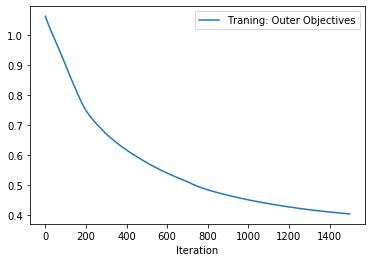

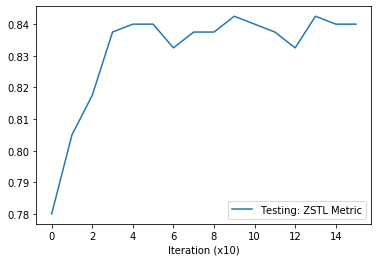

mean metric 0.8399999999999999
rho for w_kb 0.01; mu for a_kb 0.0001;
init mean test metric 0.78; align loss 0.020616261288523674
1/1500 o_loss 1.0630122658486167; m train metric 0.8483333333333337; m test metric 0.78; align loss  0.020371021702885628
100/1500 o_loss 0.9019723623991013; m train metric 0.8558333333333336; m test metric 0.805; align loss  0.019942590966820717
200/1500 o_loss 0.7493032756106307; m train metric 0.8558333333333337; m test metric 0.8175000000000002; align loss  0.01970495656132698
300/1500 o_loss 0.6700031556965163; m train metric 0.8616666666666671; m test metric 0.835; align loss  0.019534068182110786
400/1500 o_loss 0.6171947233689328; m train metric 0.8666666666666671; m test metric 0.8374999999999998; align loss  0.01935845986008644
500/1500 o_loss 0.5753540700301528; m train metric 0.8683333333333338; m test metric 0.8324999999999999; align loss  0.01921767368912697
600/1500 o_loss 0.540487885614857; m train metric 0.870416666666667; m test metric 0.83

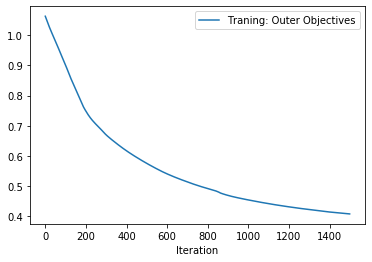

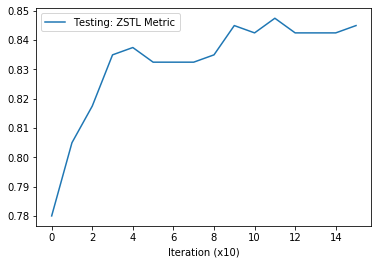

mean metric 0.845
rho for w_kb 0.01; mu for a_kb 1e-05;
init mean test metric 0.78; align loss 0.01619485579431057
1/1500 o_loss 1.0630122658486167; m train metric 0.8483333333333334; m test metric 0.78; align loss  0.015949616208672523
100/1500 o_loss 0.901731539486597; m train metric 0.8550000000000001; m test metric 0.805; align loss  0.015546265989542007
200/1500 o_loss 0.7491137539347013; m train metric 0.8562500000000004; m test metric 0.8175000000000001; align loss  0.01532580703496933
300/1500 o_loss 0.6693754098999003; m train metric 0.8620833333333336; m test metric 0.835; align loss  0.015151230618357658
400/1500 o_loss 0.6169273123145104; m train metric 0.8650000000000003; m test metric 0.8375; align loss  0.015002178028225899
500/1500 o_loss 0.5747603815980256; m train metric 0.8662500000000004; m test metric 0.8324999999999998; align loss  0.014893386512994766
600/1500 o_loss 0.5404695902640622; m train metric 0.8704166666666672; m test metric 0.8274999999999999; align lo

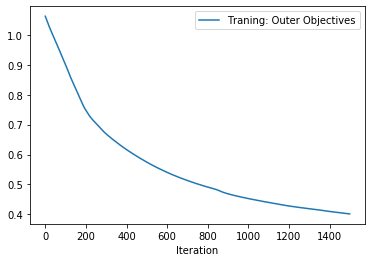

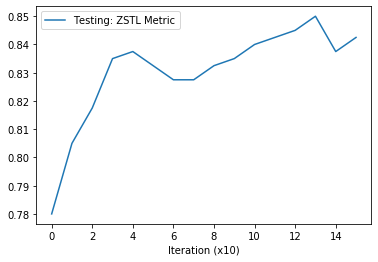

mean metric 0.8424999999999999
rho for w_kb 0.001; mu for a_kb 0.1;
init mean test metric 0.78; align loss 4.9283766746521
1/1500 o_loss 0.5567681689436237; m train metric 0.8483333333333335; m test metric 0.7800000000000001; align loss  4.928133010864258
100/1500 o_loss 0.47044534478336575; m train metric 0.8579166666666673; m test metric 0.8025; align loss  4.853111743927002
200/1500 o_loss 0.3841908844498297; m train metric 0.8645833333333337; m test metric 0.8400000000000001; align loss  4.77899169921875
300/1500 o_loss 0.35515058546637496; m train metric 0.8695833333333339; m test metric 0.85; align loss  4.706085205078125
400/1500 o_loss 0.33681076603631177; m train metric 0.8745833333333338; m test metric 0.8574999999999997; align loss  4.634419918060303
500/1500 o_loss 0.3242892375526329; m train metric 0.8841666666666673; m test metric 0.8574999999999999; align loss  4.564087390899658
600/1500 o_loss 0.3123267599381506; m train metric 0.8883333333333341; m test metric 0.854999

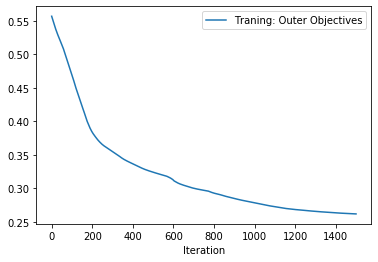

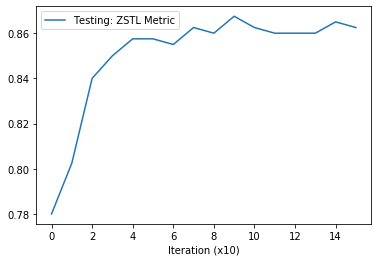

mean metric 0.8625
New best acc 0.8625
rho for w_kb 0.001; mu for a_kb 0.01;
init mean test metric 0.7800000000000001; align loss 0.5069708824157715
1/1500 o_loss 0.5567681689436237; m train metric 0.8483333333333334; m test metric 0.78; align loss  0.5067270398139954
100/1500 o_loss 0.4704438223813971; m train metric 0.857916666666667; m test metric 0.8025; align loss  0.4992416203022003
200/1500 o_loss 0.38421771690870327; m train metric 0.864583333333334; m test metric 0.8400000000000001; align loss  0.49206990003585815
300/1500 o_loss 0.35514382443701226; m train metric 0.8695833333333335; m test metric 0.8500000000000002; align loss  0.48486819863319397
400/1500 o_loss 0.3367972632870078; m train metric 0.8745833333333339; m test metric 0.8574999999999999; align loss  0.4777166247367859
500/1500 o_loss 0.3242724146693945; m train metric 0.8841666666666672; m test metric 0.8574999999999997; align loss  0.47074130177497864
600/1500 o_loss 0.3122969935337702; m train metric 0.8870833

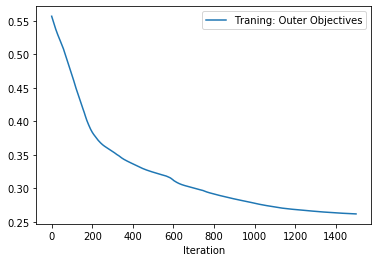

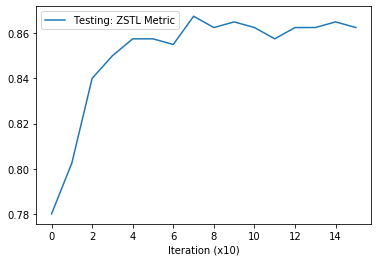

mean metric 0.8624999999999998
rho for w_kb 0.001; mu for a_kb 0.001;
init mean test metric 0.78; align loss 0.06483031809329987
1/1500 o_loss 0.5567681689436237; m train metric 0.8483333333333338; m test metric 0.78; align loss  0.06458652019500732
100/1500 o_loss 0.4708412020467222; m train metric 0.857916666666667; m test metric 0.8024999999999999; align loss  0.06382295489311218
200/1500 o_loss 0.38379749323551854; m train metric 0.8637500000000002; m test metric 0.8425; align loss  0.06329821050167084
300/1500 o_loss 0.35484912106767297; m train metric 0.8700000000000004; m test metric 0.8525000000000003; align loss  0.06263262033462524
400/1500 o_loss 0.3365428749782344; m train metric 0.8762500000000005; m test metric 0.8549999999999999; align loss  0.06191230192780495
500/1500 o_loss 0.3244071423386534; m train metric 0.8816666666666673; m test metric 0.8574999999999999; align loss  0.0612652450799942
600/1500 o_loss 0.3154572292851905; m train metric 0.8883333333333338; m test

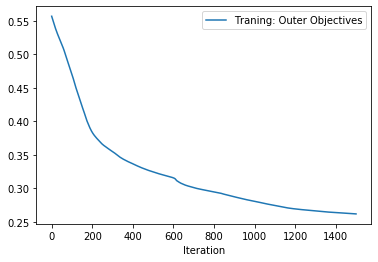

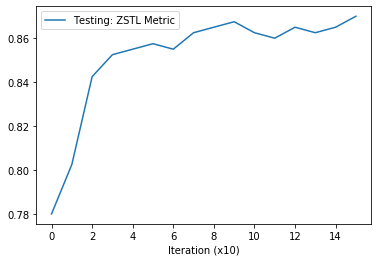

mean metric 0.8699999999999999
New best acc 0.8699999999999999
rho for w_kb 0.001; mu for a_kb 0.0001;
init mean test metric 0.78; align loss 0.020616261288523674
1/1500 o_loss 0.5567681689436237; m train metric 0.8483333333333335; m test metric 0.78; align loss  0.020372461527585983
100/1500 o_loss 0.47086091497913; m train metric 0.8587500000000002; m test metric 0.8025; align loss  0.02008873224258423
200/1500 o_loss 0.3824876359353463; m train metric 0.8641666666666671; m test metric 0.8424999999999999; align loss  0.02004213072359562
300/1500 o_loss 0.35425973469391464; m train metric 0.8725000000000003; m test metric 0.85; align loss  0.01984104886651039
400/1500 o_loss 0.33650402321169776; m train metric 0.8750000000000004; m test metric 0.8574999999999999; align loss  0.019647032022476196
500/1500 o_loss 0.3248067435498039; m train metric 0.8820833333333339; m test metric 0.8574999999999999; align loss  0.019496824592351913
600/1500 o_loss 0.31582578402012584; m train metric 0.

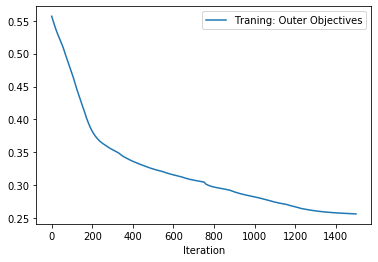

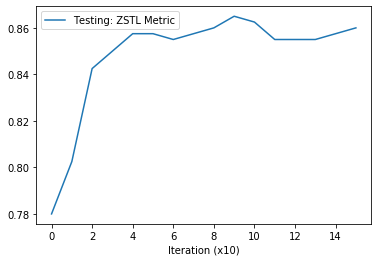

mean metric 0.8599999999999998
rho for w_kb 0.001; mu for a_kb 1e-05;
init mean test metric 0.78; align loss 0.01619485579431057
1/1500 o_loss 0.5567681689436237; m train metric 0.8483333333333338; m test metric 0.78; align loss  0.01595105603337288
100/1500 o_loss 0.47097698850557207; m train metric 0.8579166666666672; m test metric 0.7999999999999999; align loss  0.015690771862864494
200/1500 o_loss 0.38245683278267584; m train metric 0.8633333333333335; m test metric 0.8424999999999999; align loss  0.015674367547035217
300/1500 o_loss 0.3545530574396253; m train metric 0.8708333333333339; m test metric 0.8499999999999999; align loss  0.015446525067090988
400/1500 o_loss 0.33627203569437064; m train metric 0.8725000000000004; m test metric 0.8550000000000001; align loss  0.015250218100845814
500/1500 o_loss 0.3240699571867784; m train metric 0.8841666666666671; m test metric 0.8549999999999999; align loss  0.015101498924195766
600/1500 o_loss 0.3149837818617622; m train metric 0.8875

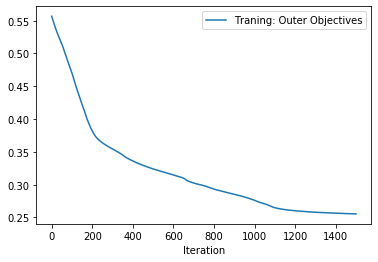

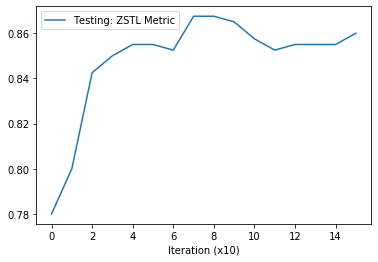

mean metric 0.86
rho for w_kb 0.0001; mu for a_kb 0.1;
init mean test metric 0.7800000000000001; align loss 4.9283766746521
1/1500 o_loss 0.5061437564591567; m train metric 0.8483333333333334; m test metric 0.7800000000000001; align loss  4.928130149841309
100/1500 o_loss 0.42441468763475615; m train metric 0.85875; m test metric 0.8025; align loss  4.852777004241943
200/1500 o_loss 0.3402817765561243; m train metric 0.867083333333334; m test metric 0.8525; align loss  4.7785749435424805
300/1500 o_loss 0.3132943736389279; m train metric 0.8733333333333336; m test metric 0.8574999999999999; align loss  4.705930709838867
400/1500 o_loss 0.29773156214505436; m train metric 0.8737500000000008; m test metric 0.8549999999999999; align loss  4.634435653686523
500/1500 o_loss 0.2869433612873157; m train metric 0.8879166666666675; m test metric 0.8549999999999998; align loss  4.564349174499512
600/1500 o_loss 0.2784130189878245; m train metric 0.8904166666666673; m test metric 0.85749999999999

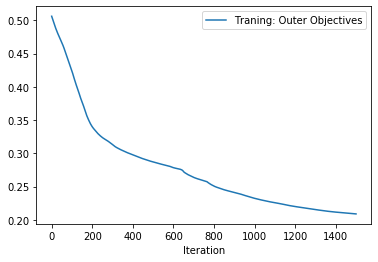

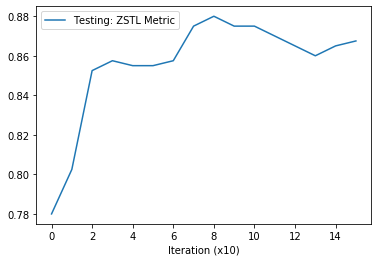

mean metric 0.8674999999999999
rho for w_kb 0.0001; mu for a_kb 0.01;
init mean test metric 0.78; align loss 0.5069708824157715
1/1500 o_loss 0.5061437564591567; m train metric 0.8483333333333338; m test metric 0.7799999999999999; align loss  0.5067242980003357
100/1500 o_loss 0.4244117199443281; m train metric 0.8587500000000002; m test metric 0.8025; align loss  0.49890464544296265
200/1500 o_loss 0.3402736374177039; m train metric 0.8670833333333332; m test metric 0.8525; align loss  0.4916524291038513
300/1500 o_loss 0.3132554949571689; m train metric 0.8737500000000005; m test metric 0.8574999999999999; align loss  0.48471158742904663
400/1500 o_loss 0.29774539154022933; m train metric 0.8737500000000004; m test metric 0.8550000000000001; align loss  0.47772955894470215
500/1500 o_loss 0.28696115566417574; m train metric 0.8879166666666672; m test metric 0.8525; align loss  0.4710015058517456
600/1500 o_loss 0.27838823242733873; m train metric 0.8904166666666676; m test metric 0.8

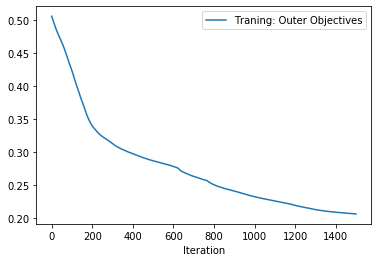

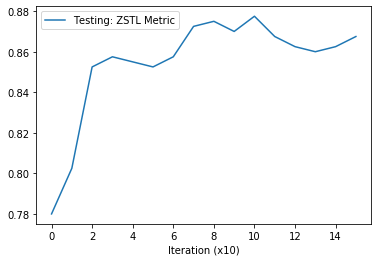

mean metric 0.8674999999999999
rho for w_kb 0.0001; mu for a_kb 0.001;
init mean test metric 0.78; align loss 0.06483031809329987
1/1500 o_loss 0.5061437564591567; m train metric 0.8483333333333339; m test metric 0.7800000000000001; align loss  0.06458375602960587
100/1500 o_loss 0.42479965326686703; m train metric 0.8583333333333336; m test metric 0.8025; align loss  0.06348997354507446
200/1500 o_loss 0.34059750630209845; m train metric 0.865833333333334; m test metric 0.8499999999999999; align loss  0.06290193647146225
300/1500 o_loss 0.31457457567254704; m train metric 0.8737500000000006; m test metric 0.8574999999999999; align loss  0.06254112720489502
400/1500 o_loss 0.29799517455200353; m train metric 0.875416666666667; m test metric 0.8525; align loss  0.0619988813996315
500/1500 o_loss 0.2871579101930062; m train metric 0.8870833333333337; m test metric 0.8574999999999999; align loss  0.061525795608758926
600/1500 o_loss 0.2789201588680347; m train metric 0.891250000000001; m 

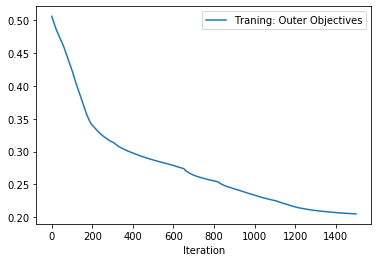

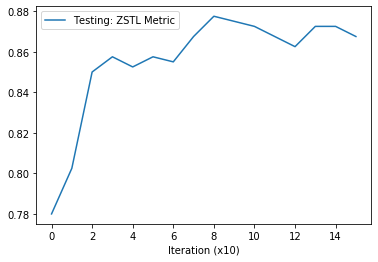

mean metric 0.8674999999999997
rho for w_kb 0.0001; mu for a_kb 0.0001;
init mean test metric 0.78; align loss 0.020616261288523674
1/1500 o_loss 0.5061437564591567; m train metric 0.8483333333333335; m test metric 0.7800000000000001; align loss  0.020369701087474823
100/1500 o_loss 0.4246623397804797; m train metric 0.8587500000000009; m test metric 0.7999999999999999; align loss  0.01975221559405327
200/1500 o_loss 0.3389978495426476; m train metric 0.8658333333333335; m test metric 0.85; align loss  0.019636984914541245
300/1500 o_loss 0.31367918622369567; m train metric 0.8745833333333342; m test metric 0.8625; align loss  0.019675996154546738
400/1500 o_loss 0.3027707447297871; m train metric 0.8787500000000008; m test metric 0.8525; align loss  0.019764646887779236
500/1500 o_loss 0.292663000865529; m train metric 0.8825000000000003; m test metric 0.8524999999999998; align loss  0.01991746947169304
600/1500 o_loss 0.28160574693853657; m train metric 0.8908333333333341; m test met

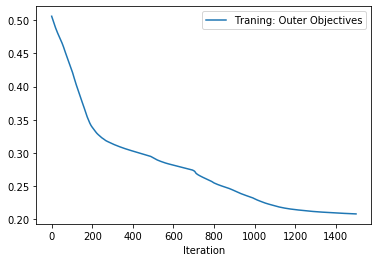

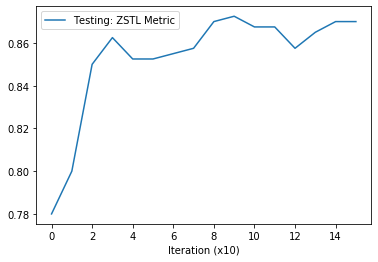

mean metric 0.8699999999999999
New best acc 0.8699999999999999
rho for w_kb 0.0001; mu for a_kb 1e-05;
init mean test metric 0.78; align loss 0.01619485579431057
1/1500 o_loss 0.5061437564591567; m train metric 0.8483333333333338; m test metric 0.78; align loss  0.01594829559326172
100/1500 o_loss 0.42470753397792577; m train metric 0.8587500000000006; m test metric 0.8; align loss  0.015352237038314342
200/1500 o_loss 0.33887604403619964; m train metric 0.8670833333333335; m test metric 0.8525000000000003; align loss  0.015256502665579319
300/1500 o_loss 0.3110849644057453; m train metric 0.8708333333333338; m test metric 0.8575000000000002; align loss  0.01524000521749258
400/1500 o_loss 0.2967159552189211; m train metric 0.8750000000000008; m test metric 0.86; align loss  0.015174755826592445
500/1500 o_loss 0.28722638996938865; m train metric 0.8858333333333337; m test metric 0.8549999999999999; align loss  0.015198254026472569
600/1500 o_loss 0.27974754174550376; m train metric 0.

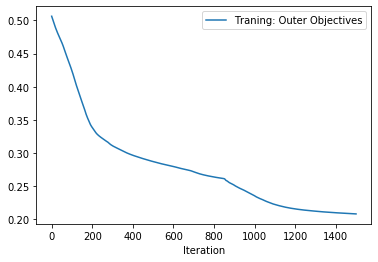

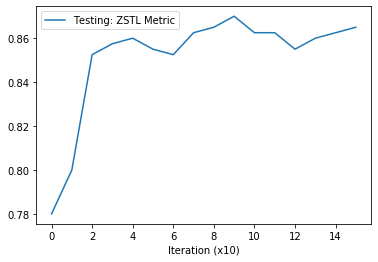

mean metric 0.8649999999999999
rho for w_kb 1e-05; mu for a_kb 0.1;
init mean test metric 0.7800000000000001; align loss 4.9283766746521
1/1500 o_loss 0.501081315757862; m train metric 0.8483333333333333; m test metric 0.78; align loss  4.92812967300415
100/1500 o_loss 0.41951813127379867; m train metric 0.8587500000000005; m test metric 0.8; align loss  4.852749824523926
200/1500 o_loss 0.33584907577605916; m train metric 0.866666666666667; m test metric 0.8499999999999999; align loss  4.7785444259643555
300/1500 o_loss 0.30864211367831257; m train metric 0.8737500000000007; m test metric 0.8575000000000002; align loss  4.705929279327393
400/1500 o_loss 0.29295747889361035; m train metric 0.8737500000000006; m test metric 0.8574999999999999; align loss  4.634498596191406
500/1500 o_loss 0.28188111902757856; m train metric 0.886250000000001; m test metric 0.8574999999999999; align loss  4.5645036697387695
600/1500 o_loss 0.2720719847168463; m train metric 0.8916666666666676; m test met

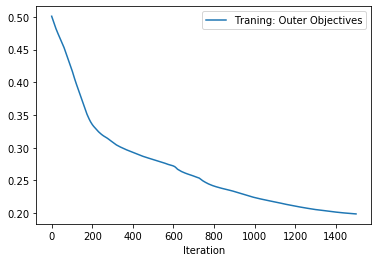

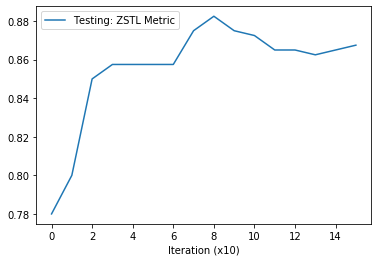

mean metric 0.8674999999999999
rho for w_kb 1e-05; mu for a_kb 0.01;
init mean test metric 0.78; align loss 0.5069708824157715
1/1500 o_loss 0.501081315757862; m train metric 0.8483333333333339; m test metric 0.78; align loss  0.5067239999771118
100/1500 o_loss 0.41952106918518745; m train metric 0.8587500000000003; m test metric 0.8; align loss  0.4988774061203003
200/1500 o_loss 0.3358486905655203; m train metric 0.8666666666666668; m test metric 0.85; align loss  0.49162137508392334
300/1500 o_loss 0.3085451147247416; m train metric 0.8737500000000004; m test metric 0.8575000000000002; align loss  0.484709233045578
400/1500 o_loss 0.2929636239811468; m train metric 0.8737500000000006; m test metric 0.8550000000000001; align loss  0.47779199481010437
500/1500 o_loss 0.28188064860490464; m train metric 0.8862500000000005; m test metric 0.8574999999999999; align loss  0.47115465998649597
600/1500 o_loss 0.2721567086914244; m train metric 0.8916666666666673; m test metric 0.857499999999

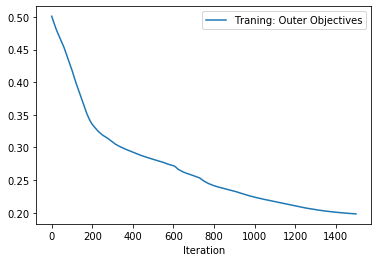

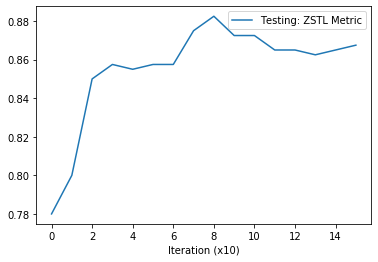

mean metric 0.8674999999999999
rho for w_kb 1e-05; mu for a_kb 0.001;
init mean test metric 0.78; align loss 0.06483031809329987
1/1500 o_loss 0.501081315757862; m train metric 0.8483333333333338; m test metric 0.78; align loss  0.06458347290754318
100/1500 o_loss 0.41987242026953026; m train metric 0.8583333333333338; m test metric 0.8025; align loss  0.06346249580383301
200/1500 o_loss 0.3361277933348902; m train metric 0.8658333333333341; m test metric 0.8474999999999998; align loss  0.06287173181772232
300/1500 o_loss 0.30991427856497467; m train metric 0.8741666666666671; m test metric 0.8574999999999999; align loss  0.06253071129322052
400/1500 o_loss 0.2932130223372951; m train metric 0.87375; m test metric 0.8574999999999999; align loss  0.06205881014466286
500/1500 o_loss 0.28242037786403673; m train metric 0.8875000000000003; m test metric 0.8574999999999999; align loss  0.06167775020003319
600/1500 o_loss 0.27372502905782314; m train metric 0.8920833333333339; m test metric 

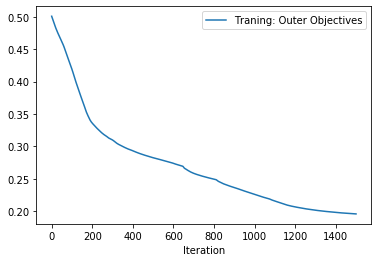

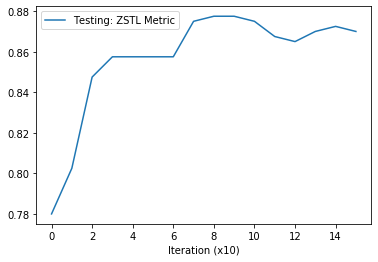

mean metric 0.8699999999999998
rho for w_kb 1e-05; mu for a_kb 0.0001;
init mean test metric 0.78; align loss 0.020616261288523674
1/1500 o_loss 0.501081315757862; m train metric 0.8483333333333337; m test metric 0.7800000000000001; align loss  0.02036941796541214
100/1500 o_loss 0.419639987735233; m train metric 0.8587500000000007; m test metric 0.7999999999999999; align loss  0.019719522446393967
200/1500 o_loss 0.33457878823392095; m train metric 0.8666666666666673; m test metric 0.85; align loss  0.019602429121732712
300/1500 o_loss 0.3092370930593461; m train metric 0.8741666666666669; m test metric 0.8625; align loss  0.01966318115592003
400/1500 o_loss 0.29824234417950113; m train metric 0.8800000000000004; m test metric 0.8524999999999998; align loss  0.019779236987233162
500/1500 o_loss 0.2855580503237434; m train metric 0.8829166666666669; m test metric 0.8524999999999997; align loss  0.019925544038414955
600/1500 o_loss 0.27675020686971646; m train metric 0.8904166666666672;

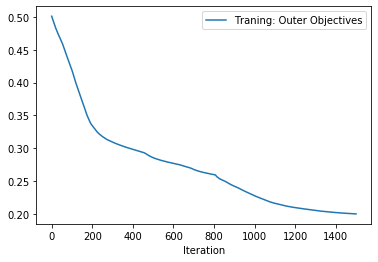

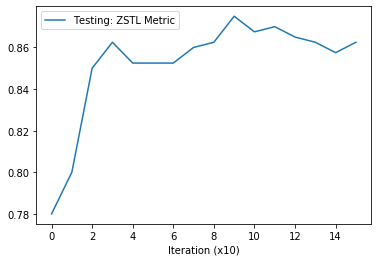

mean metric 0.8624999999999998
rho for w_kb 1e-05; mu for a_kb 1e-05;
init mean test metric 0.7800000000000002; align loss 0.01619485579431057
1/1500 o_loss 0.501081315757862; m train metric 0.8483333333333333; m test metric 0.78; align loss  0.015948012471199036
100/1500 o_loss 0.4195854747706714; m train metric 0.8587500000000005; m test metric 0.8025; align loss  0.01532354298979044
200/1500 o_loss 0.33430138044059277; m train metric 0.867916666666667; m test metric 0.85; align loss  0.01521956454962492
300/1500 o_loss 0.3064946484635584; m train metric 0.8720833333333339; m test metric 0.8574999999999999; align loss  0.015245120041072369
400/1500 o_loss 0.29201481634130083; m train metric 0.8754166666666671; m test metric 0.8574999999999999; align loss  0.015226218849420547
500/1500 o_loss 0.28242427559259037; m train metric 0.8858333333333337; m test metric 0.8549999999999999; align loss  0.015333590097725391
600/1500 o_loss 0.2748007684984865; m train metric 0.8891666666666669; m

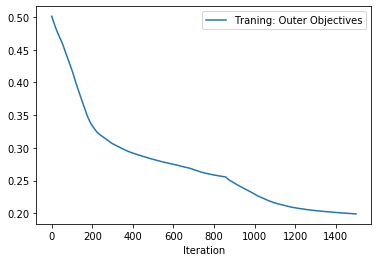

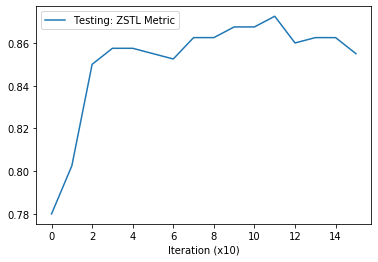

mean metric 0.8550000000000001
best_hp  {'mu': 0.0001, 'rho': 0.0001}


In [4]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)
d  = support_w.size()[0]
print(d)


indx = train_indx
val_indx = list(np.random.choice(indx, size=20, replace=False))
print(len(val_indx))
train_indx_splited = [x for x in indx if x not in val_indx]
print(len(train_indx_splited))

val_data = utils.Dataset([dataset[d] for d in val_indx])
train_splited_data = utils.Dataset([dataset[d] for d in train_indx_splited])
val_loader = DataLoader(val_data, batch_size=len(val_indx), shuffle=True)
train_splited_loader = DataLoader(train_splited_data, batch_size=len(train_indx_splited), shuffle=True)

best_hp = utils.hp_select_binClass(train_splited_loader, val_loader, support_loader, d, dm, net, shape_record, device)
print('best_hp ', best_hp)

5
{'rho': 0.0001, 'mu': 0.0001, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.0001, 'dm': 5, 'd': 8, 'model_shape': {0: [(1, 8)]}, 'atten_activation': 'Sparsemax'}
init mean test metric 0.8469999999999999; align loss 0.01990450546145439
1/1800 o_loss 0.5370845647528768; m train metric 0.8385714285714285; m test metric 0.8469999999999999; align loss  0.020405307412147522
100/1800 o_loss 0.4396899648409869; m train metric 0.8496428571428577; m test metric 0.8639999999999998; align loss  0.01988275721669197
200/1800 o_loss 0.34442384715325064; m train metric 0.8653571428571432; m test metric 0.875; align loss  0.019947323948144913
300/1800 o_loss 0.3136523344820099; m train metric 0.8796428571428581; m test metric 0.8889999999999998; align loss  0.019949909299612045
400/1800 o_loss 0.2998444826741304; m train metric 0.8875000000000006; m test metric 0.8910000000000002; align loss  0.019595585763454437
500/1800 o_loss 0.2918095988886697; m train metric 0.8882142857142865; m test

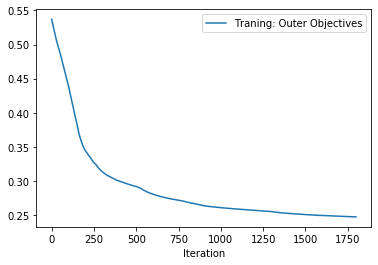

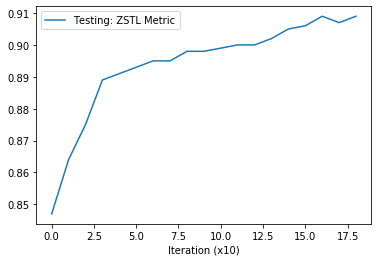

0

In [5]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)

param_dict = {}
param_dict['rho'] = best_hp['rho']
param_dict['mu'] = best_hp['mu']
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'
print(param_dict)


ZSTL_model = ZSTL(support_w, support_a, support_x, net, param_dict, device)
ZSTL_model.train(train_loader, test_loader, max_iter=1800)


In [6]:
def genSplits(dataset, train_size, test_size, support_size, T, train_batch_size=140):
    indx = [ x for x in range(len(dataset))]
    support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
    print(len(support_indx))
    temp = [x for x in indx if x not in support_indx]
    train_indx = list(np.random.choice(temp, size=train_size, replace=False))
    temp = [x for x in temp if x not in train_indx]
    print(len(train_indx))
    test_indx = temp
    print(len(test_indx))


    support_data = utils.Dataset([dataset[d] for d in support_indx])
    train_data = utils.Dataset([dataset[d] for d in train_indx])
    test_data = utils.Dataset([dataset[d] for d in test_indx])

    support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
    train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)

    return support_loader, train_loader, test_loader

train_size1 = 140
test_size1 = 50
support_size1 = 10
support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, T, train_batch_size=train_size1)

10
140
50


{'rho': 0.0001, 'mu': 0.0001, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.0001, 'dm': 5, 'd': 8, 'model_shape': {0: [(1, 8)]}, 'atten_activation': 'Sparsemax'}
10
140
50
init mean test metric 0.8290000000000001; align loss 0.014901760034263134
1/1800 o_loss 0.5582746986698891; m train metric 0.825; m test metric 0.83; align loss  0.01541170384734869
100/1800 o_loss 0.41050732065258283; m train metric 0.8525000000000005; m test metric 0.843; align loss  0.015030442737042904
200/1800 o_loss 0.345329287648201; m train metric 0.8732142857142863; m test metric 0.8479999999999999; align loss  0.014923895709216595
300/1800 o_loss 0.3232312105596066; m train metric 0.8800000000000006; m test metric 0.8490000000000002; align loss  0.014955437742173672
400/1800 o_loss 0.3046928258479706; m train metric 0.8846428571428575; m test metric 0.8590000000000001; align loss  0.015177600085735321
500/1800 o_loss 0.29416627000485146; m train metric 0.886785714285715; m test metric 0.862999999

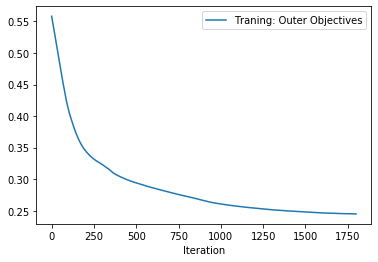

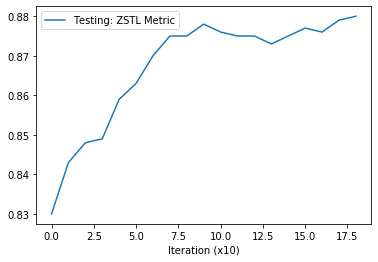

mean acc  tensor(0.8800, dtype=torch.float64)
10
140
50
init mean test metric 0.8270000000000002; align loss 0.03202370926737785
1/1800 o_loss 0.6002339609499489; m train metric 0.8275000000000001; m test metric 0.8270000000000001; align loss  0.028991704806685448
100/1800 o_loss 0.4456667755597404; m train metric 0.8589285714285717; m test metric 0.8510000000000001; align loss  0.028259431943297386
200/1800 o_loss 0.3613417168014816; m train metric 0.8807142857142856; m test metric 0.8730000000000001; align loss  0.02720552682876587
300/1800 o_loss 0.31502288697021347; m train metric 0.8871428571428575; m test metric 0.8869999999999999; align loss  0.026538673788309097
400/1800 o_loss 0.29318022834403173; m train metric 0.8921428571428576; m test metric 0.889; align loss  0.02592184767127037
500/1800 o_loss 0.2829357008316687; m train metric 0.8975000000000007; m test metric 0.8899999999999999; align loss  0.025953594595193863
600/1800 o_loss 0.2757279776835016; m train metric 0.89678

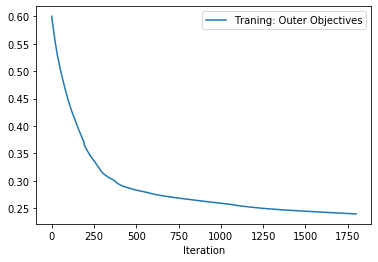

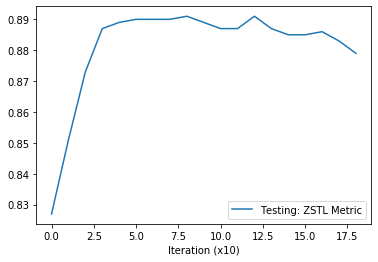

mean acc  tensor(0.8790, dtype=torch.float64)
10
140
50
init mean test metric 0.8029999999999999; align loss 0.0325651653110981
1/1800 o_loss 0.5547818222615336; m train metric 0.7921428571428573; m test metric 0.8039999999999999; align loss  0.036600738763809204
100/1800 o_loss 0.4284117118189377; m train metric 0.8367857142857146; m test metric 0.841; align loss  0.03630189970135689
200/1800 o_loss 0.3484739287490291; m train metric 0.8628571428571429; m test metric 0.882; align loss  0.03383945673704147
300/1800 o_loss 0.32036975642134036; m train metric 0.8707142857142862; m test metric 0.8890000000000002; align loss  0.030295489355921745
400/1800 o_loss 0.305501826719514; m train metric 0.8757142857142863; m test metric 0.8920000000000003; align loss  0.027277404442429543
500/1800 o_loss 0.2956707593984902; m train metric 0.8771428571428574; m test metric 0.894; align loss  0.02517886273562908
600/1800 o_loss 0.2868455096813185; m train metric 0.879642857142858; m test metric 0.89

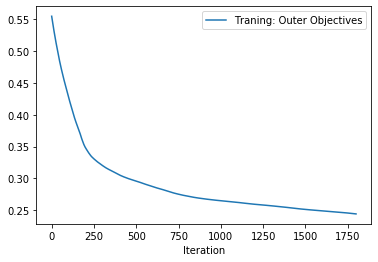

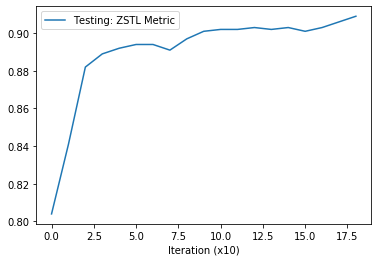

mean acc  tensor(0.9090, dtype=torch.float64)
10
140
50
init mean test metric 0.835; align loss 0.008950772695243359
1/1800 o_loss 0.6454552938230336; m train metric 0.8221428571428573; m test metric 0.8349999999999999; align loss  0.009440535679459572
100/1800 o_loss 0.49283004117065243; m train metric 0.85; m test metric 0.8610000000000001; align loss  0.009678538888692856
200/1800 o_loss 0.3972126102607165; m train metric 0.8610714285714292; m test metric 0.8700000000000001; align loss  0.009676236659288406
300/1800 o_loss 0.35277367838259255; m train metric 0.8692857142857146; m test metric 0.8749999999999994; align loss  0.009153255261480808
400/1800 o_loss 0.3258983759874744; m train metric 0.8753571428571427; m test metric 0.8830000000000001; align loss  0.008863858878612518
500/1800 o_loss 0.30696812402456997; m train metric 0.8817857142857151; m test metric 0.8910000000000001; align loss  0.008968671783804893
600/1800 o_loss 0.2926997037471405; m train metric 0.888214285714286

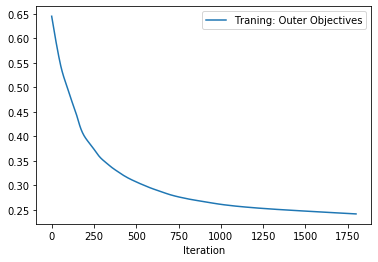

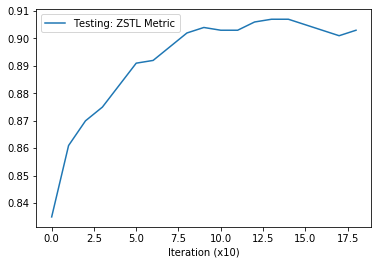

mean acc  tensor(0.9030, dtype=torch.float64)
10
140
50
init mean test metric 0.7979999999999999; align loss 0.03512894734740257
1/1800 o_loss 0.5516244724525937; m train metric 0.826071428571429; m test metric 0.7980000000000002; align loss  0.03920908644795418
100/1800 o_loss 0.45640278885673197; m train metric 0.8492857142857151; m test metric 0.8310000000000002; align loss  0.03473282605409622
200/1800 o_loss 0.4019834946175771; m train metric 0.8664285714285719; m test metric 0.8720000000000002; align loss  0.03179667145013809
300/1800 o_loss 0.35045522858521766; m train metric 0.8767857142857152; m test metric 0.8720000000000002; align loss  0.03024437464773655
400/1800 o_loss 0.30718839604939735; m train metric 0.8835714285714295; m test metric 0.8780000000000002; align loss  0.03052341751754284
500/1800 o_loss 0.2941315235437027; m train metric 0.8867857142857151; m test metric 0.8750000000000003; align loss  0.030318737030029297
600/1800 o_loss 0.2850595909969083; m train metr

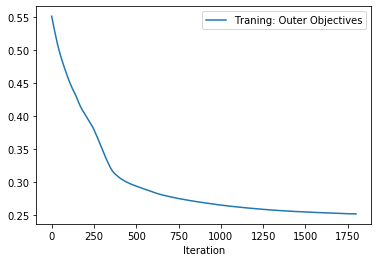

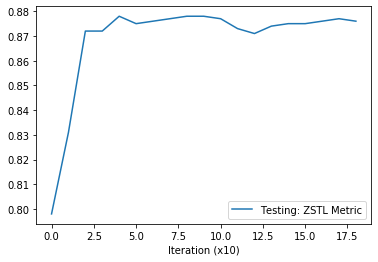

mean acc  tensor(0.8760, dtype=torch.float64)
10
140
50
init mean test metric 0.7959999999999998; align loss 0.027968278154730797
1/1800 o_loss 0.6476207716390491; m train metric 0.845; m test metric 0.7949999999999998; align loss  0.02802816778421402
100/1800 o_loss 0.5692350618807333; m train metric 0.8525000000000007; m test metric 0.8160000000000003; align loss  0.025864068418741226
200/1800 o_loss 0.4923720606469682; m train metric 0.8592857142857148; m test metric 0.8290000000000002; align loss  0.024899201467633247
300/1800 o_loss 0.40809858529163257; m train metric 0.8639285714285718; m test metric 0.835; align loss  0.025124674662947655
400/1800 o_loss 0.3499443187777485; m train metric 0.8721428571428577; m test metric 0.847; align loss  0.0255703404545784
500/1800 o_loss 0.30364138404173513; m train metric 0.8846428571428581; m test metric 0.858; align loss  0.02492472343146801
600/1800 o_loss 0.28637523373056734; m train metric 0.889642857142858; m test metric 0.85800000000

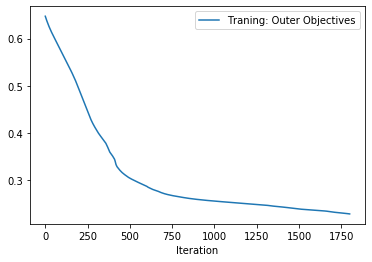

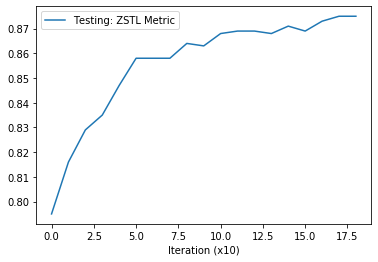

mean acc  tensor(0.8750, dtype=torch.float64)
10
140
50
init mean test metric 0.8290000000000001; align loss 0.02432338520884514
1/1800 o_loss 0.5893080009546663; m train metric 0.8207142857142862; m test metric 0.8289999999999997; align loss  0.023990927264094353
100/1800 o_loss 0.47628063459747605; m train metric 0.8353571428571431; m test metric 0.845; align loss  0.02311806008219719
200/1800 o_loss 0.40171944689271705; m train metric 0.8460714285714291; m test metric 0.839; align loss  0.02304871752858162
300/1800 o_loss 0.3478724568949214; m train metric 0.8564285714285713; m test metric 0.8460000000000001; align loss  0.022959619760513306
400/1800 o_loss 0.3260887107013592; m train metric 0.8635714285714291; m test metric 0.848; align loss  0.021988773718476295
500/1800 o_loss 0.31246779490528365; m train metric 0.8721428571428576; m test metric 0.85; align loss  0.020618975162506104
600/1800 o_loss 0.3023324656832431; m train metric 0.8757142857142863; m test metric 0.8569999999

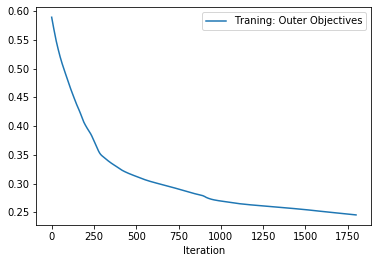

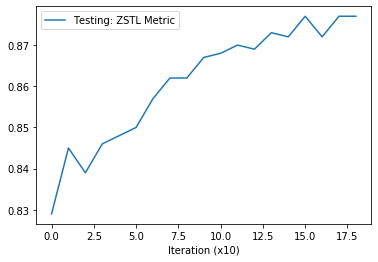

mean acc  tensor(0.8770, dtype=torch.float64)
10
140
50
init mean test metric 0.858; align loss 0.014299457892775536
1/1800 o_loss 0.6419342331322176; m train metric 0.8278571428571431; m test metric 0.8570000000000002; align loss  0.01394694671034813
100/1800 o_loss 0.5289025393713798; m train metric 0.8510714285714289; m test metric 0.8699999999999999; align loss  0.012268761172890663
200/1800 o_loss 0.4539386752194592; m train metric 0.8607142857142861; m test metric 0.8819999999999998; align loss  0.011401195079088211
300/1800 o_loss 0.37496204605059963; m train metric 0.8678571428571432; m test metric 0.8860000000000001; align loss  0.011321882717311382
400/1800 o_loss 0.31924809723028114; m train metric 0.8771428571428577; m test metric 0.8749999999999997; align loss  0.011721034534275532
500/1800 o_loss 0.30107147923803756; m train metric 0.8875000000000004; m test metric 0.885; align loss  0.011987840756773949
600/1800 o_loss 0.29027722432677233; m train metric 0.89071428571428

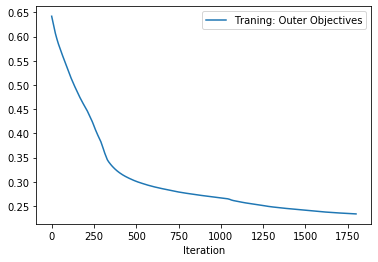

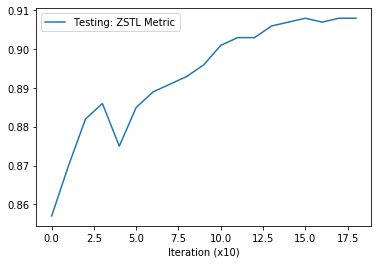

mean acc  tensor(0.9080, dtype=torch.float64)
10
140
50
init mean test metric 0.8219999999999997; align loss 0.019573291763663292
1/1800 o_loss 0.5022382339462638; m train metric 0.8275000000000003; m test metric 0.8219999999999997; align loss  0.02248578518629074
100/1800 o_loss 0.41110402303082605; m train metric 0.8507142857142855; m test metric 0.8489999999999999; align loss  0.021697796881198883
200/1800 o_loss 0.3666363950020501; m train metric 0.860714285714286; m test metric 0.8529999999999999; align loss  0.021789826452732086
300/1800 o_loss 0.32936581720464997; m train metric 0.8714285714285719; m test metric 0.857; align loss  0.02195574715733528
400/1800 o_loss 0.30635518081752316; m train metric 0.8775000000000006; m test metric 0.86; align loss  0.02212410233914852
500/1800 o_loss 0.28600232929789593; m train metric 0.8871428571428579; m test metric 0.8689999999999998; align loss  0.022374171763658524
600/1800 o_loss 0.2681091488472053; m train metric 0.8953571428571434; 

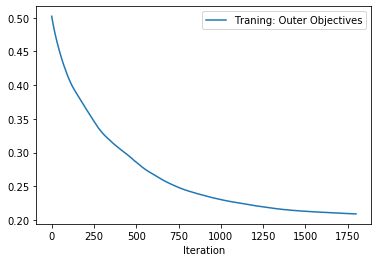

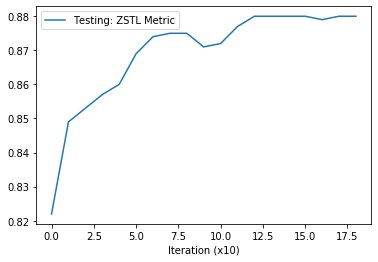

mean acc  tensor(0.8800, dtype=torch.float64)
10
140
50
init mean test metric 0.8119999999999997; align loss 0.01301553938537836
1/1800 o_loss 0.7069650482120259; m train metric 0.8075; m test metric 0.8120000000000002; align loss  0.012368481606245041
100/1800 o_loss 0.5793702275625296; m train metric 0.83; m test metric 0.8360000000000001; align loss  0.010952871292829514
200/1800 o_loss 0.4864654520393482; m train metric 0.8403571428571429; m test metric 0.836; align loss  0.010612137615680695
300/1800 o_loss 0.444416662797864; m train metric 0.8410714285714287; m test metric 0.8389999999999997; align loss  0.010727383196353912
400/1800 o_loss 0.4076129552908242; m train metric 0.8500000000000003; m test metric 0.8470000000000002; align loss  0.01083117164671421
500/1800 o_loss 0.3752342921282564; m train metric 0.8557142857142862; m test metric 0.8439999999999999; align loss  0.011276686564087868
600/1800 o_loss 0.3494798120111227; m train metric 0.8617857142857147; m test metric 0

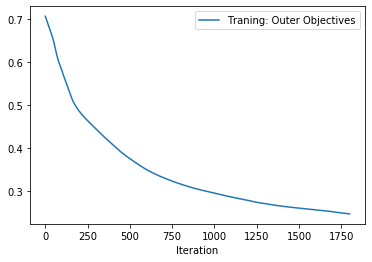

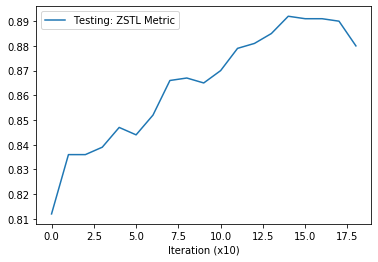

mean acc  tensor(0.8800, dtype=torch.float64)


In [7]:
exp_results = []
Run = 10
print(param_dict)
for r in range(Run):
    support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, T, train_batch_size=train_size1)
    support_a, support_w, support_x, support_y = next(iter(support_loader))
    support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
    support_a = support_a.squeeze().t()
    support_w = support_w.squeeze().t()
    ZSTL_model = ZSTL(support_w, support_a, support_x, net, param_dict, device)
    ZSTL_model.train(train_loader, test_loader, max_iter=1800)
    mean_acc = ZSTL_model.zero_shot_transfer(test_loader)
    print('mean acc ', mean_acc)
    exp_results.append(utils.toNumpy(mean_acc))


In [8]:
import scipy
from scipy import stats
print(exp_results)
sample = np.array(exp_results)
confidence_level = 0.95
degrees_freedom = sample.size - 1
sample_mean = np.mean(sample)
sample_standard_error = scipy.stats.sem(sample)

confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
print(sample_mean)
print(confidence_interval)
print(confidence_interval - sample_mean)

[array(0.88), array(0.879), array(0.909), array(0.903), array(0.876), array(0.875), array(0.877), array(0.908), array(0.88), array(0.88)]
0.8867
(0.8767074543526341, 0.896692545647366)
[-0.00999255  0.00999255]


In [9]:
print(param_dict)

{'rho': 0.0001, 'mu': 0.0001, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.0001, 'dm': 5, 'd': 8, 'model_shape': {0: [(1, 8)]}, 'atten_activation': 'Sparsemax'}
